In [1]:

import pandas as pd
import matplotlib.pyplot as plt
# import sklearn, catboost, xgboost
import cubist
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

from sklearn.preprocessing import StandardScaler

In [2]:
# Predict your new samples of silica nanoparticles by running this code, and PLEASE WAIT until the results have been downloaded
independent_id = 116
data = pd.read_csv(r'./Main_Indepedent_Dataset.csv', encoding='unicode_escape')

def convert(Cell_viability):
    if Cell_viability == 'Cytotoxic':
        return 1
    if Cell_viability == 'Non_cytotoxic':
        return 0
    else:
        return ''

def convert_back(Cell_viability):
    if Cell_viability == 1:
        return 'Cytotoxic'
    if Cell_viability == 0:
        return 'Non_cytotoxic'
    else:
      return ''

data['convert'] = data['Cell_viability'].apply(convert)
data = data.drop('Cell_viability', axis=1)
data = data.rename(columns={'convert':'Cell_viability'})

shuffled_main_dataset = data[data['Publication_id'] < independent_id].sample(frac=1, random_state=2022)
independent_dataset = data[data['Publication_id'] >= independent_id]
data = pd.concat([shuffled_main_dataset, independent_dataset])

feature_list = [
    "Concentration_µg/ml",
    "SiO$_{2}$NP_medium_serum",
    "Surface_modification",
    "Hydrodynamic_size_culture_nm",
    "Cell_culture",
    "Cell_id",
    "Primary_size_nm",
    "Surface_charge_water",
    "Primary_size_verification",
    "Cell_morphology",
    "Cell_organ",
    "Exposure_time_h",
    "SiO$_{2}$NP_shape",
    "SiO$_{2}$NP_source",
    "Zeta_potential_water_mV",
    "Cell_source",
    "Cell_age",
    "Hydrodynamic_size_water_nm",
    "PDI_water",
    "SiO$_{2}$NP_synthesis",
    "Surface_area_m2/g",
    "Publication_id",
    "Cell_viability"
]

data = data[feature_list]
# 在所有数据上编码

X = pd.get_dummies(data)
X = X.drop([
    'SiO$_{2}$NP_medium_serum_15%_FBS',
    'Cell_morphology_microglia',

    'Cell_organ_heart',

    'Cell_id_MPMC/3t3',

    'Surface_modification_CHO',
    'Hydrodynamic_size_water_nm_not_determined',
    'Cell_source_hamster',
    "Cell_viability"
], axis=1)

y = data[['Cell_viability', 'Publication_id']]
y = y[y['Publication_id'] < independent_id]
y = y.drop('Publication_id',axis=1)
y = y.to_numpy().ravel()

y_val = data[['Cell_viability','Publication_id']]
y_val = y_val[y_val['Publication_id'] >= independent_id]
y_val =  y_val.drop('Publication_id',axis=1)
y_val = y_val.values

X_val = X[X['Publication_id'] >= independent_id]
X_val = X_val.drop('Publication_id',axis=1)
X_val = X_val.sort_index(ascending=True)
# X_test_shap = X_test
X_val = X_val.values.reshape(-1,len(X_val.columns))

X = X[X['Publication_id'] < independent_id]
X = X.drop('Publication_id',axis=1)

In [3]:
X

,Concentration_µg/ml,Primary_size_nm,Exposure_time_h,Surface_area_m2/g,SiO$_{2}$NP_medium_serum_0.1%_FBS,SiO$_{2}$NP_medium_serum_0.5%_FBS,SiO$_{2}$NP_medium_serum_1%_FBS,SiO$_{2}$NP_medium_serum_10%_FBS,SiO$_{2}$NP_medium_serum_2%_FBS,SiO$_{2}$NP_medium_serum_20%_FBS,...,PDI_water_0.201-0.3,PDI_water_0.301-0.4,PDI_water_0.401-0.5,PDI_water_0.501-0.6,PDI_water_0.701-0.8,PDI_water_less_0.101,PDI_water_not_determined,SiO$_{2}$NP_synthesis_high_temperature,SiO$_{2}$NP_synthesis_low_temperature,SiO$_{2}$NP_synthesis_not_available
3828,50.0,59.72,72.0,49.724000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
189,167.0,15.20,48.0,179.425837,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
644,90.0,19.40,24.0,145.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3655,40.0,13.00,24.0,203.920000,False,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False
604,10.0,13.80,24.0,275.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,300.0,11.70,4.0,233.100233,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
24,100.0,100.00,24.0,27.272727,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
2066,100.0,85.69,72.0,31.800000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
173,667.0,80.21,48.0,34.001655,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [4]:
y

array([1, 0, 1, ..., 1, 0, 0])

In [5]:
X

,Concentration_µg/ml,Primary_size_nm,Exposure_time_h,Surface_area_m2/g,SiO$_{2}$NP_medium_serum_0.1%_FBS,SiO$_{2}$NP_medium_serum_0.5%_FBS,SiO$_{2}$NP_medium_serum_1%_FBS,SiO$_{2}$NP_medium_serum_10%_FBS,SiO$_{2}$NP_medium_serum_2%_FBS,SiO$_{2}$NP_medium_serum_20%_FBS,...,PDI_water_0.201-0.3,PDI_water_0.301-0.4,PDI_water_0.401-0.5,PDI_water_0.501-0.6,PDI_water_0.701-0.8,PDI_water_less_0.101,PDI_water_not_determined,SiO$_{2}$NP_synthesis_high_temperature,SiO$_{2}$NP_synthesis_low_temperature,SiO$_{2}$NP_synthesis_not_available
3828,50.0,59.72,72.0,49.724000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
189,167.0,15.20,48.0,179.425837,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
644,90.0,19.40,24.0,145.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3655,40.0,13.00,24.0,203.920000,False,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False
604,10.0,13.80,24.0,275.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,300.0,11.70,4.0,233.100233,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
24,100.0,100.00,24.0,27.272727,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
2066,100.0,85.69,72.0,31.800000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
173,667.0,80.21,48.0,34.001655,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [6]:
# -----------------------------
# 完整示例：TabPFN + SHAP
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
# -----------------------------
# 4. 拆分训练/测试集
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [7]:
feature_names = X.columns.tolist()
print(f"Original Feature Names: {feature_names}")

Original Feature Names: ['Concentration_µg/ml', 'Primary_size_nm', 'Exposure_time_h', 'Surface_area_m2/g', 'SiO$_{2}$NP_medium_serum_0.1%_FBS', 'SiO$_{2}$NP_medium_serum_0.5%_FBS', 'SiO$_{2}$NP_medium_serum_1%_FBS', 'SiO$_{2}$NP_medium_serum_10%_FBS', 'SiO$_{2}$NP_medium_serum_2%_FBS', 'SiO$_{2}$NP_medium_serum_20%_FBS', 'SiO$_{2}$NP_medium_serum_40%_FBS', 'SiO$_{2}$NP_medium_serum_5%_FBS', 'SiO$_{2}$NP_medium_serum_BSA', 'SiO$_{2}$NP_medium_serum_serum_free', 'Surface_modification_L-arginine-R', 'Surface_modification_SO3H', 'Surface_modification_alumina', 'Surface_modification_amine', 'Surface_modification_carboxyl', 'Surface_modification_chitosan', 'Surface_modification_citrate', 'Surface_modification_dansylamide', 'Surface_modification_digestive_enzymes', 'Surface_modification_unmodified', 'Hydrodynamic_size_culture_nm_101-150', 'Hydrodynamic_size_culture_nm_151-200', 'Hydrodynamic_size_culture_nm_201-300', 'Hydrodynamic_size_culture_nm_26-50', 'Hydrodynamic_size_culture_nm_301-400'

In [8]:
from tabpfn_extensions import interpretability

/root/miniconda3/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [9]:
X

,Concentration_µg/ml,Primary_size_nm,Exposure_time_h,Surface_area_m2/g,SiO$_{2}$NP_medium_serum_0.1%_FBS,SiO$_{2}$NP_medium_serum_0.5%_FBS,SiO$_{2}$NP_medium_serum_1%_FBS,SiO$_{2}$NP_medium_serum_10%_FBS,SiO$_{2}$NP_medium_serum_2%_FBS,SiO$_{2}$NP_medium_serum_20%_FBS,...,PDI_water_0.201-0.3,PDI_water_0.301-0.4,PDI_water_0.401-0.5,PDI_water_0.501-0.6,PDI_water_0.701-0.8,PDI_water_less_0.101,PDI_water_not_determined,SiO$_{2}$NP_synthesis_high_temperature,SiO$_{2}$NP_synthesis_low_temperature,SiO$_{2}$NP_synthesis_not_available
3828,50.0,59.72,72.0,49.724000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
189,167.0,15.20,48.0,179.425837,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
644,90.0,19.40,24.0,145.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3655,40.0,13.00,24.0,203.920000,False,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False
604,10.0,13.80,24.0,275.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,300.0,11.70,4.0,233.100233,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
24,100.0,100.00,24.0,27.272727,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
2066,100.0,85.69,72.0,31.800000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
173,667.0,80.21,48.0,34.001655,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [10]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from tabpfn import TabPFNClassifier
from sklearn.svm import SVC
# Cubist 没有直接的 Python 分类实现，这里用类似思想的 XGBoost 替代示例
from xgboost import XGBClassifier
# 假设有 cubist 库也可略过或自行替换

# 1 - GBDT  → GradientBoostingClassifier
gbdt_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=0.8
)

# 2 - Random Forest  → RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=9,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
)

# 3 - 多元线性回归 → 逻辑回归(Logistic Regression)
lr_model = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=1000
)

# 4 - Cubist → 这里无法直接用 Cubist 做分类
#    可使用 XGBoost 替代（或保留为 R 语言版本）
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic'   # 二分类；多分类改为 'multi:softprob' 并设置 num_class
)

# 5 - SVR → SVC
svr_model = SVC(
    C=10,
    kernel='rbf',
    gamma=0.1,
    probability=True            # 需要预测概率时
)

# 6 - BPNN（使用 MLPClassifier 模拟 BPNN）
bpnn_model = MLPClassifier(
    hidden_layer_sizes=(100, 100, 100),
    activation='relu',
    solver='adam',
    alpha=0.3,
    batch_size=200,
    learning_rate_init=0.05,
    momentum=0.9,
    validation_fraction=0.2,
    shuffle=True,
    random_state=0,
    tol=1e-4,
    max_iter=2000
)

#4-CUBIST(Parameters are determined through grid search in the R language script.)
cubist_model = cubist.Cubist(n_committees =100,neighbors=9)


CatBoost_model = CatBoostClassifier(learning_rate= 0.05,max_depth= 7,random_state=2022)
TabPFN_model = TabPFNClassifier()

In [11]:
# Training
gbdt_model.fit(X_train, y_train)
print("1-gbdt training complete。")
#xgb_model.fit(X_train_scaled, y_train)
print("2-rf training complete。")
rf_model.fit(X_train, y_train)
# print("2-rf training complete。")
#mlp.fit(X_train_scaled, y_train)
#print("4-mlp training complete。")
lr_model.fit(X_train, y_train)
print("3-lr training complete。")
xgb_model.fit(X_train, y_train)
print("4-xgb training complete。")
svr_model.fit(X_train, y_train) 
print("5-svr training complete。") 
#lssvm.fit(X_train_scaled, y_train)
#print("6-lssvm training complete。")
bpnn_model.fit(X_train, y_train)
print("6-bpnn training complete。")
# cubist_model.fit(X_train, y_train)
# print("7-PSO_ANN training complete。")
# kan_model(calhous_dataset['test_input'])
CatBoost_model.fit(X_train, y_train)
print("7-CatBoost_model training complete。")
TabPFN_model.fit(X_train, y_train)
print("8-TabPFN training complete。")

1-gbdt training complete。


/root/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3-lr training complete。
4-cubist training complete。
5-svr training complete。
6-bpnn training complete。
7-PSO_ANN training complete。
0:	learn: 0.6723952	total: 49.9ms	remaining: 49.8s
1:	learn: 0.6547565	total: 53.2ms	remaining: 26.6s
2:	learn: 0.6361233	total: 56.4ms	remaining: 18.7s
3:	learn: 0.6190608	total: 59.1ms	remaining: 14.7s
4:	learn: 0.6059966	total: 62.1ms	remaining: 12.4s
5:	learn: 0.5911308	total: 65.1ms	remaining: 10.8s
6:	learn: 0.5789011	total: 68.2ms	remaining: 9.68s
7:	learn: 0.5650630	total: 71.1ms	remaining: 8.82s
8:	learn: 0.5538023	total: 73.8ms	remaining: 8.12s
9:	learn: 0.5422525	total: 76.8ms	remaining: 7.6s
10:	learn: 0.5314509	total: 79.4ms	remaining: 7.14s
11:	learn: 0.5232903	total: 81.9ms	remaining: 6.74s
12:	learn: 0.5166889	total: 84.6ms	remaining: 6.42s
13:	learn: 0.5075278	total: 87.4ms	remaining: 6.15s
14:	learn: 0.5004738	total: 90.2ms	remaining: 5.92s
15:	learn: 0.4928682	total: 92.9ms	remaining: 5.71s
16:	learn: 0.4868691	total: 95.3ms	remaining: 5

In [12]:
X_train

,Concentration_µg/ml,Primary_size_nm,Exposure_time_h,Surface_area_m2/g,SiO$_{2}$NP_medium_serum_0.1%_FBS,SiO$_{2}$NP_medium_serum_0.5%_FBS,SiO$_{2}$NP_medium_serum_1%_FBS,SiO$_{2}$NP_medium_serum_10%_FBS,SiO$_{2}$NP_medium_serum_2%_FBS,SiO$_{2}$NP_medium_serum_20%_FBS,...,PDI_water_0.201-0.3,PDI_water_0.301-0.4,PDI_water_0.401-0.5,PDI_water_0.501-0.6,PDI_water_0.701-0.8,PDI_water_less_0.101,PDI_water_not_determined,SiO$_{2}$NP_synthesis_high_temperature,SiO$_{2}$NP_synthesis_low_temperature,SiO$_{2}$NP_synthesis_not_available
2694,32.5,30.0,5.0,90.909091,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3101,80.0,20.0,24.0,136.363636,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
3143,3000.0,92.0,24.0,29.644269,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
3411,200.0,13.0,24.0,203.920000,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
629,80.0,16.4,24.0,220.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,200.0,15.0,24.0,181.818182,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
2210,12.5,16.0,24.0,170.454545,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
317,667.0,13.3,48.0,205.058100,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2328,300.0,25.0,18.0,109.090909,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [14]:
X_test

,Concentration_µg/ml,Primary_size_nm,Exposure_time_h,Surface_area_m2/g,SiO$_{2}$NP_medium_serum_0.1%_FBS,SiO$_{2}$NP_medium_serum_0.5%_FBS,SiO$_{2}$NP_medium_serum_1%_FBS,SiO$_{2}$NP_medium_serum_10%_FBS,SiO$_{2}$NP_medium_serum_2%_FBS,SiO$_{2}$NP_medium_serum_20%_FBS,...,PDI_water_0.201-0.3,PDI_water_0.301-0.4,PDI_water_0.401-0.5,PDI_water_0.501-0.6,PDI_water_0.701-0.8,PDI_water_less_0.101,PDI_water_not_determined,SiO$_{2}$NP_synthesis_high_temperature,SiO$_{2}$NP_synthesis_low_temperature,SiO$_{2}$NP_synthesis_not_available
1856,100.000000,64.4,20.0,65.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4104,6.250000,300.0,27.0,8.365867,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
576,10.000000,104.0,24.0,41.200000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
646,150.000000,19.4,24.0,145.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
819,40.000000,7.0,24.0,389.610390,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,100.000000,118.1,24.0,23.092910,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
1944,65.600000,16.4,24.0,220.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2161,20.000000,30.0,168.0,130.000000,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,True,False
2144,600.000000,21.0,72.0,230.000000,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,True,False


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
# -----------------------------
# 6. 测试准确率
# -----------------------------
predictions = gbdt_model.predict(X_test)
print("Accuracy:", classification_report(y_test, predictions,digits=4))


# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))
# -----------------------------
# 6. 测试准确率
# -----------------------------
predictions = rf_model.predict(X_test)
print("Accuracy:", classification_report(y_test, predictions,digits=4))
from sklearn.metrics import classification_report, confusion_matrix

# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))
# -----------------------------
# 6. 测试准确率
# -----------------------------
predictions = lr_model.predict(X_test)
print("Accuracy:", classification_report(y_test, predictions,digits=4))
from sklearn.metrics import classification_report, confusion_matrix

# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))
# -----------------------------
# 6. 测试准确率
# -----------------------------
predictions = xgb_model.predict(X_test)
print("Accuracy:", classification_report(y_test, predictions,digits=4))
from sklearn.metrics import classification_report, confusion_matrix

# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))
# -----------------------------
# 6. 测试准确率
# -----------------------------
predictions = svr_model.predict(X_test)
print("Accuracy:", classification_report(y_test, predictions,digits=4))
from sklearn.metrics import classification_report, confusion_matrix

# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))
# -----------------------------
# 6. 测试准确率
# -----------------------------
predictions = bpnn_model.predict(X_test)
print("Accuracy:", classification_report(y_test, predictions,digits=4))
from sklearn.metrics import classification_report, confusion_matrix

# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))
# -----------------------------
# 6. 测试准确率
# -----------------------------
# predictions = cubist_model.predict(X_test)
# print("Accuracy:", classification_report(y_test, predictions,digits=4))
# from sklearn.metrics import classification_report, confusion_matrix

# # 混淆矩阵
# print("\nConfusion Matrix:\n")
# print(confusion_matrix(y_test, predictions))
# -----------------------------
predictions = CatBoost_model.predict(X_test)
print("Accuracy:", classification_report(y_test, predictions,digits=4))
from sklearn.metrics import classification_report, confusion_matrix

# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))


predictions = TabPFN_model.predict(X_test)
print("Accuracy:", classification_report(y_test, predictions,digits=4))
from sklearn.metrics import classification_report, confusion_matrix

# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))

Accuracy:               precision    recall  f1-score   support

           0     0.8553    0.9343    0.8931       791
           1     0.8610    0.7204    0.7844       447

    accuracy                         0.8570      1238
   macro avg     0.8581    0.8273    0.8387      1238
weighted avg     0.8574    0.8570    0.8538      1238


Confusion Matrix:

[[739  52]
 [125 322]]
Accuracy:               precision    recall  f1-score   support

           0     0.7836    0.9659    0.8652       791
           1     0.8973    0.5280    0.6648       447

    accuracy                         0.8078      1238
   macro avg     0.8405    0.7469    0.7650      1238
weighted avg     0.8247    0.8078    0.7929      1238


Confusion Matrix:

[[764  27]
 [211 236]]
Accuracy:               precision    recall  f1-score   support

           0     0.7494    0.8546    0.7986       791
           1     0.6577    0.4944    0.5645       447

    accuracy                         0.7246      1238
   macro avg

In [17]:
# # -----------------------------
# # 6. 测试准确率
# # -----------------------------
# predictions = clf.predict(X_test)
# print("Accuracy:", classification_report(y_test, predictions,digits=4))
# from sklearn.metrics import classification_report, confusion_matrix

# # 混淆矩阵
# print("\nConfusion Matrix:\n")
# print(confusion_matrix(y_test, predictions))

Classification Report:

               precision    recall  f1-score   support

Non_cytotoxic     0.8790    0.9368    0.9070       791
    cytotoxic     0.8734    0.7718    0.8195       447

     accuracy                         0.8772      1238
    macro avg     0.8762    0.8543    0.8632      1238
 weighted avg     0.8770    0.8772    0.8754      1238

               Non_cytotoxic  cytotoxic
Non_cytotoxic            741         50
cytotoxic                102        345


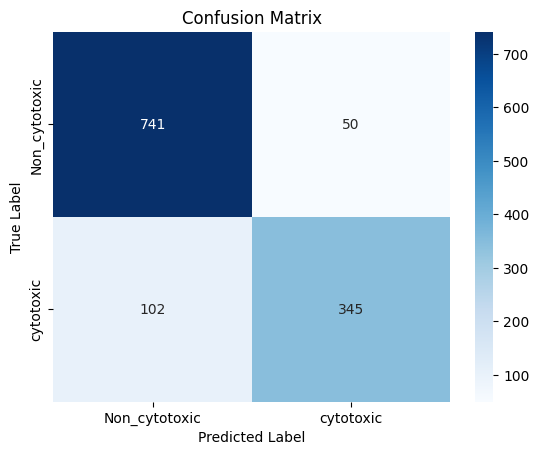

In [18]:
import seaborn as sns
# 指定标签顺序
labels = ["Non_cytotoxic", "cytotoxic"]
# 打印分类报告
print("Classification Report:\n")
print(classification_report(y_test, predictions,
                            target_names=labels,   # 指定类别名
                            digits=4))
# 打印混淆矩阵
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm,
                     index=[f"{n}" for n in labels],
                     columns=[f"{n}" for n in labels])
print(cm_df)

# (可选) 可视化热力图
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
X_train

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import pandas as pd

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 保存每折指标
acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []
for clf in [gbdt_model, rf_model,lr_model,xgb_model,svr_model,bpnn_model,CatBoost_model]:
        
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # clf = gbdt_model
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    
        # 如果是二分类，可以用 predict_proba 计算 AUC-ROC
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]  # 取正类概率
        else:
            # 没有 predict_proba，用 decision_function
            y_proba = clf.decision_function(X_test)
    
        # 分类报告
        report = classification_report(y_test, y_pred, target_names=labels, digits=4, output_dict=True)
    
        # 提取指标
        acc_list.append(report['accuracy'])
        precision_list.append(report['macro avg']['precision'])
        recall_list.append(report['macro avg']['recall'])
        f1_list.append(report['macro avg']['f1-score'])
        try:
            auc_score = roc_auc_score(y_test, y_proba)
        except:
            auc_score = np.nan
        auc_list.append(auc_score)
    
        # 输出每折结果
        # print(f"\n=== Fold {fold} ===")
        # print(classification_report(y_test, y_pred, target_names=labels, digits=4))
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm,
                             index=[f"{n}" for n in labels],
                             columns=[f"{n}" for n in labels])
        # print("\nConfusion Matrix:\n", cm_df)
        # (可选) 可视化热力图
        # sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        # plt.ylabel("True Label")
        # plt.xlabel("Predicted Label")
        # plt.title("Confusion Matrix")
        # plt.show()
    # 输出平均值 ± 标准差
    print(f"\n==={clf} Overall Metrics ===")
    metrics = {
        "Accuracy": acc_list,
        "Precision": precision_list,
        "Recall": recall_list,
        "F1-score": f1_list,
        "AUC-ROC": auc_list
    }
    
    for m, values in metrics.items():
        mean = np.nanmean(values)
        std = np.nanstd(values)
        print(f"{m}: {mean:.4f} ± {std:.4f}")



===GradientBoostingClassifier(subsample=0.8) Overall Metrics ===
Accuracy: 0.8557 ± 0.0059
Precision: 0.8527 ± 0.0031
Recall: 0.8267 ± 0.0115
F1-score: 0.8366 ± 0.0087
AUC-ROC: 0.9290 ± 0.0040

===RandomForestClassifier(max_depth=9, n_estimators=500) Overall Metrics ===
Accuracy: 0.8344 ± 0.0227
Precision: 0.8534 ± 0.0062
Recall: 0.7863 ± 0.0422
F1-score: 0.8013 ± 0.0372
AUC-ROC: 0.9275 ± 0.0037


/root/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n


===LogisticRegression(max_iter=1000) Overall Metrics ===
Accuracy: 0.7974 ± 0.0559
Precision: 0.8017 ± 0.0736
Recall: 0.7481 ± 0.0643
F1-score: 0.7604 ± 0.0656
AUC-ROC: 0.8765 ± 0.0724

===XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...) Overall Metrics ===
Accuracy: 0.8105 ± 0.0536
Precision

/root/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.10


===MLPClassifier(alpha=0.3, batch_size=200, hidden_layer_sizes=(100, 100, 100),
              learning_rate_init=0.05, max_iter=2000, random_state=0,
              validation_fraction=0.2) Overall Metrics ===
Accuracy: 0.7852 ± 0.0666
Precision: 0.7528 ± 0.1553
Recall: 0.7295 ± 0.0951
F1-score: 0.7290 ± 0.1258
AUC-ROC: 0.8475 ± 0.1065
0:	learn: 0.6695076	total: 3.74ms	remaining: 3.73s
1:	learn: 0.6479709	total: 7.33ms	remaining: 3.66s
2:	learn: 0.6287269	total: 10.6ms	remaining: 3.53s
3:	learn: 0.6148817	total: 26.6ms	remaining: 6.62s
4:	learn: 0.6014182	total: 29.9ms	remaining: 5.96s
5:	learn: 0.5867485	total: 33.3ms	remaining: 5.52s
6:	learn: 0.5740996	total: 36.6ms	remaining: 5.19s
7:	learn: 0.5610776	total: 40.2ms	remaining: 4.98s
8:	learn: 0.5487587	total: 43.6ms	remaining: 4.8s
9:	learn: 0.5375263	total: 47ms	remaining: 4.65s
10:	learn: 0.5289230	total: 50.2ms	remaining: 4.51s
11:	learn: 0.5203625	total: 53.1ms	remaining: 4.37s
12:	learn: 0.5118688	total: 56.3ms	remaining: 4.28s

In [ ]:
# reports

               precision    recall  f1-score   support

Non_cytotoxic     0.8782    0.8059    0.8405       680
    cytotoxic     0.5302    0.6622    0.5889       225

     accuracy                         0.7702       905
    macro avg     0.7042    0.7341    0.7147       905
 weighted avg     0.7917    0.7702    0.7779       905



/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


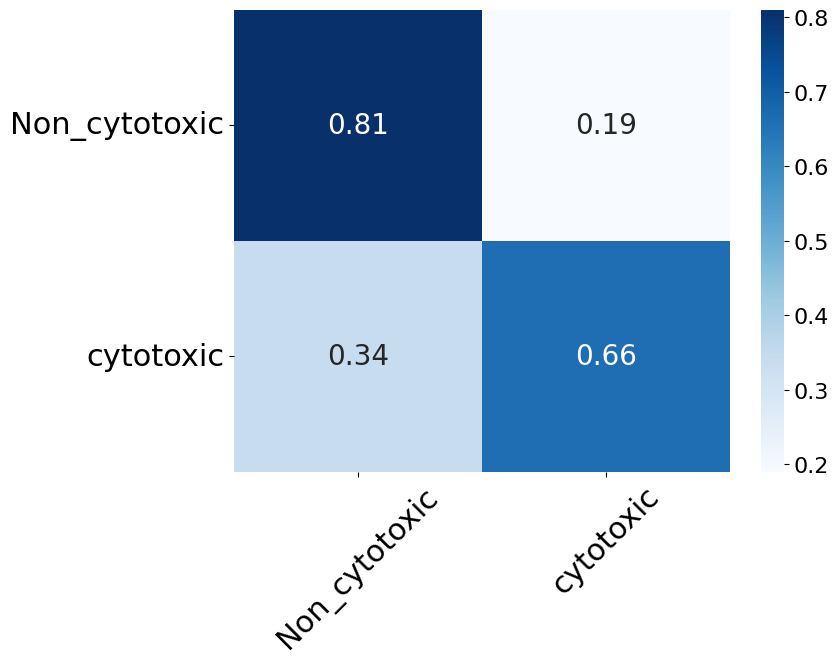


===GradientBoostingClassifier(subsample=0.8) AUC ROC ===
0.8297941176470589


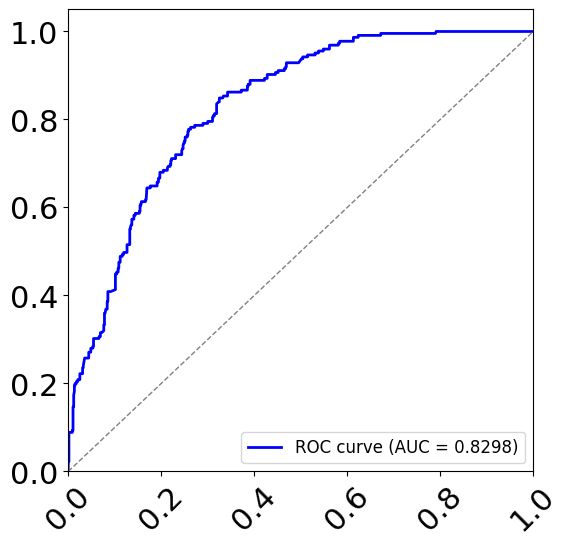

/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


               precision    recall  f1-score   support

Non_cytotoxic     0.7920    0.9853    0.8781       680
    cytotoxic     0.8305    0.2178    0.3451       225

     accuracy                         0.7945       905
    macro avg     0.8112    0.6015    0.6116       905
 weighted avg     0.8015    0.7945    0.7456       905



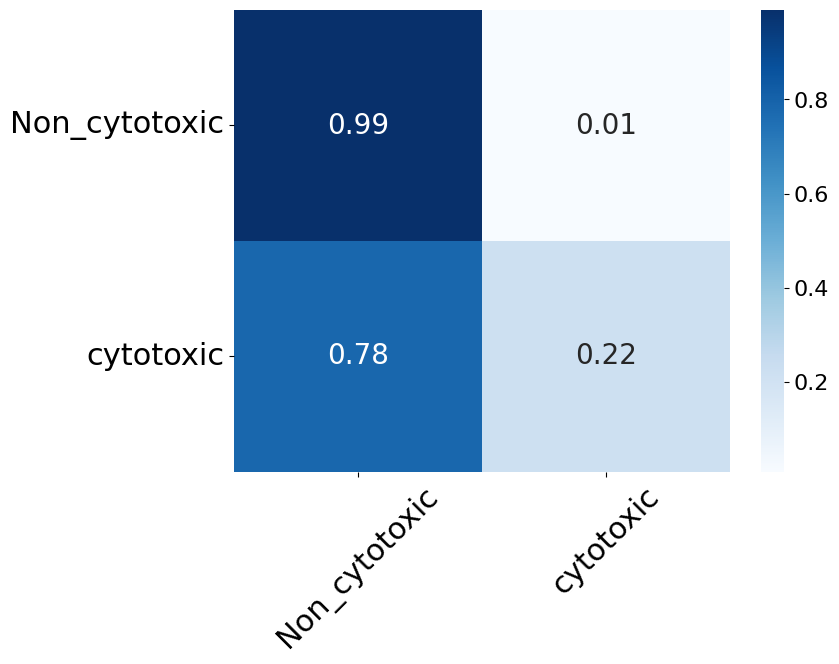


===RandomForestClassifier(max_depth=9, n_estimators=500) AUC ROC ===
0.8070424836601306


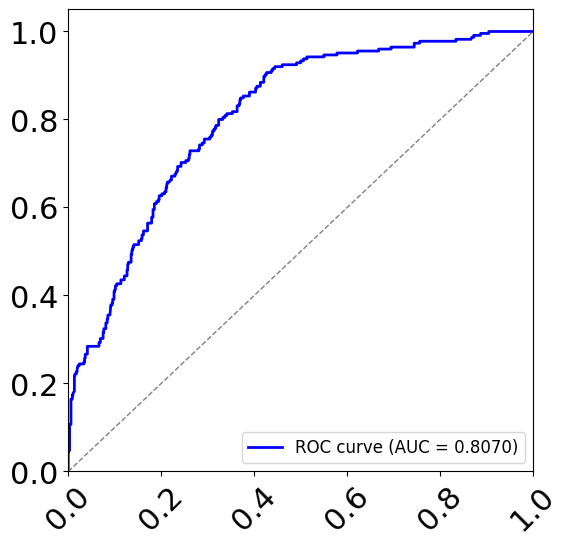

/root/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


               precision    recall  f1-score   support

Non_cytotoxic     0.7969    0.7559    0.7758       680
    cytotoxic     0.3615    0.4178    0.3876       225

     accuracy                         0.6718       905
    macro avg     0.5792    0.5868    0.5817       905
 weighted avg     0.6887    0.6718    0.6793       905



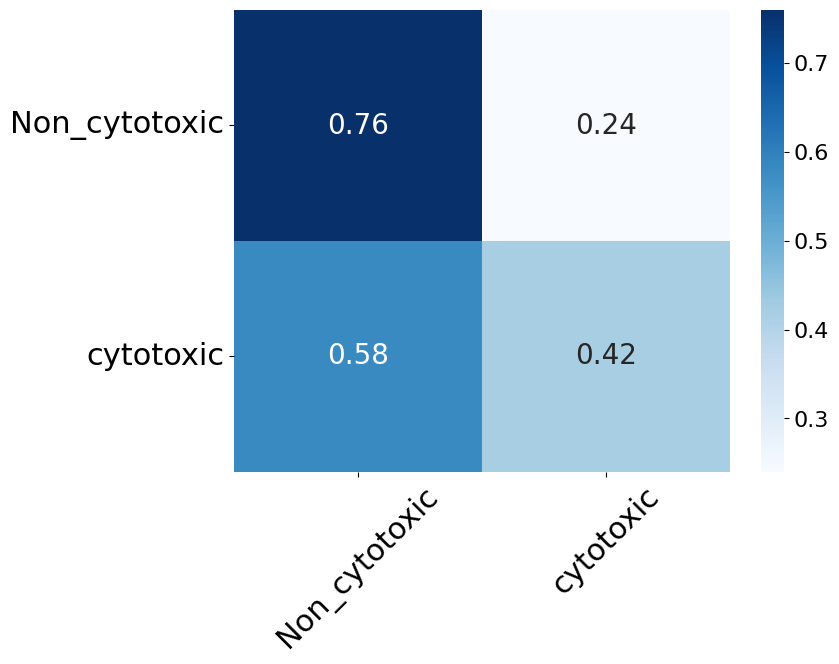


===LogisticRegression(max_iter=1000) AUC ROC ===
0.6546666666666667


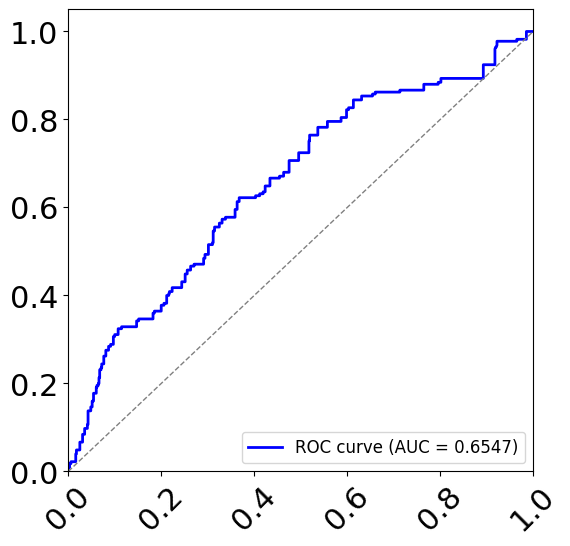

               precision    recall  f1-score   support

Non_cytotoxic     0.8885    0.8441    0.8658       680
    cytotoxic     0.5907    0.6800    0.6322       225

     accuracy                         0.8033       905
    macro avg     0.7396    0.7621    0.7490       905
 weighted avg     0.8145    0.8033    0.8077       905



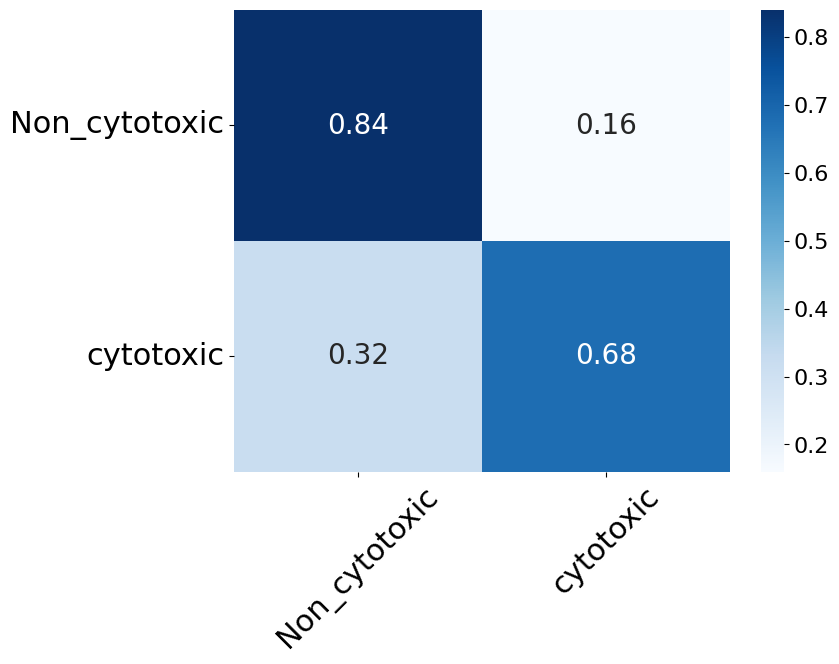


===XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...) AUC ROC ===
0.8529183006535948


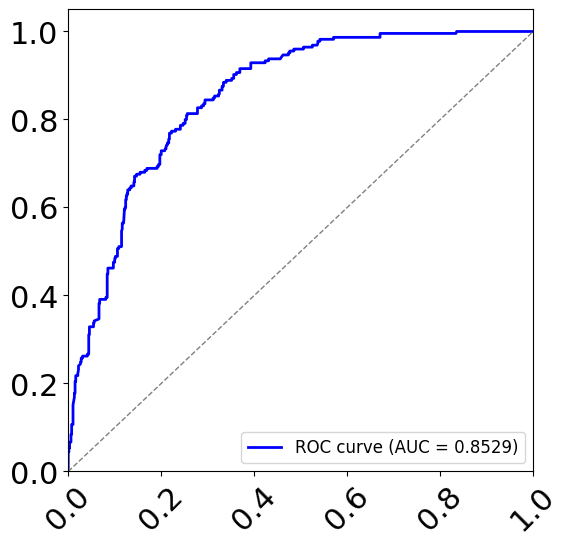

/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


               precision    recall  f1-score   support

Non_cytotoxic     0.7780    0.9588    0.8590       680
    cytotoxic     0.5821    0.1733    0.2671       225

     accuracy                         0.7635       905
    macro avg     0.6801    0.5661    0.5631       905
 weighted avg     0.7293    0.7635    0.7119       905



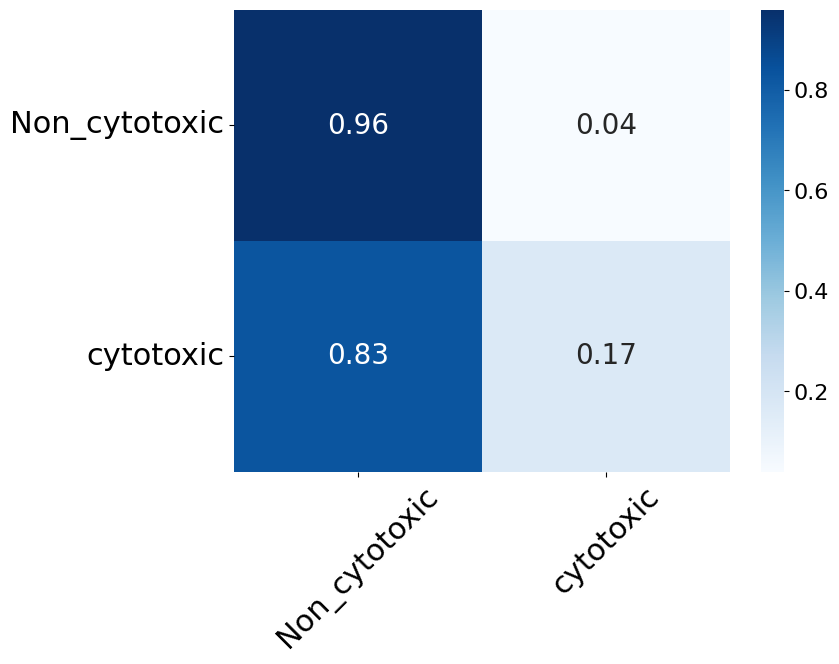


===SVC(C=10, gamma=0.1, probability=True) AUC ROC ===
0.6800915032679739


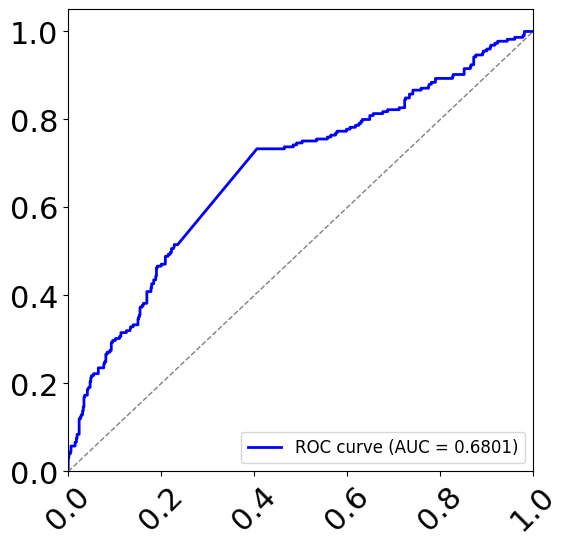

               precision    recall  f1-score   support

Non_cytotoxic     0.8487    0.8000    0.8236       680
    cytotoxic     0.4848    0.5689    0.5235       225

     accuracy                         0.7425       905
    macro avg     0.6668    0.6844    0.6736       905
 weighted avg     0.7582    0.7425    0.7490       905



/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


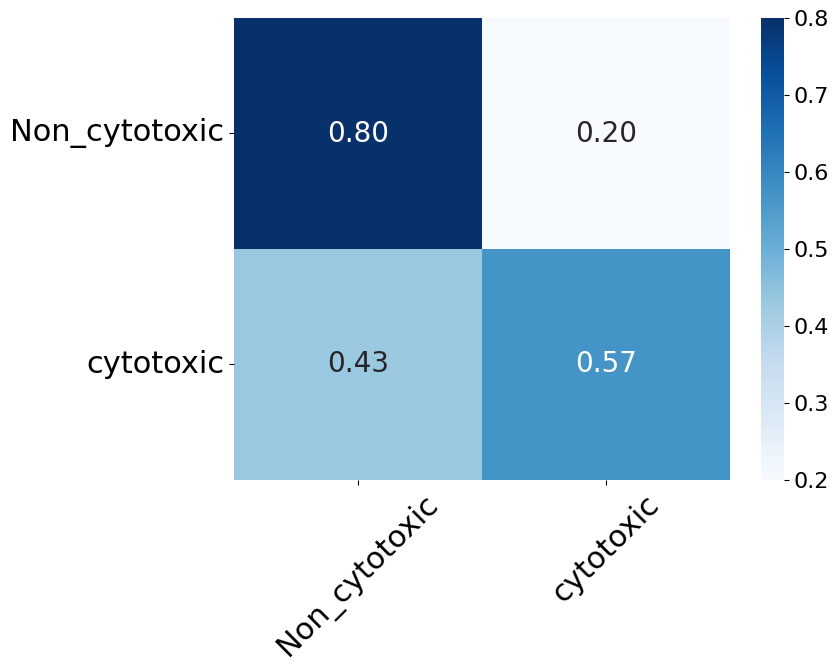


===MLPClassifier(alpha=0.3, batch_size=200, hidden_layer_sizes=(100, 100, 100),
              learning_rate_init=0.05, max_iter=2000, random_state=0,
              validation_fraction=0.2) AUC ROC ===
0.7847712418300653


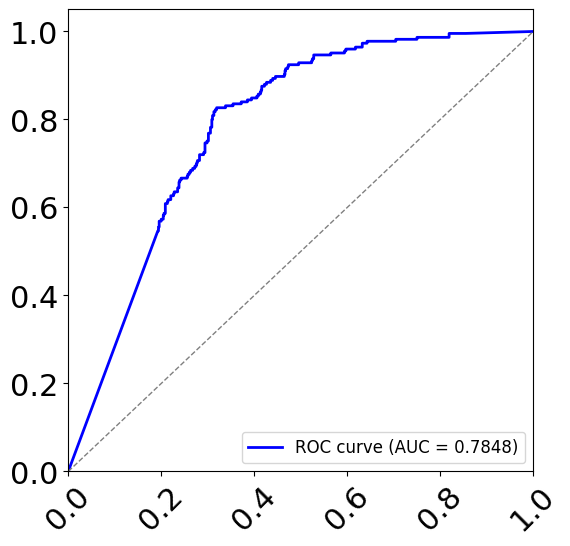

0:	learn: 0.6703048	total: 3.2ms	remaining: 3.19s
1:	learn: 0.6491685	total: 6.72ms	remaining: 3.35s
2:	learn: 0.6303133	total: 10.1ms	remaining: 3.36s
3:	learn: 0.6157371	total: 13.3ms	remaining: 3.31s
4:	learn: 0.6001790	total: 16.7ms	remaining: 3.32s
5:	learn: 0.5930532	total: 18ms	remaining: 2.99s
6:	learn: 0.5786928	total: 20.7ms	remaining: 2.94s
7:	learn: 0.5662880	total: 23.6ms	remaining: 2.92s
8:	learn: 0.5561013	total: 26.6ms	remaining: 2.93s
9:	learn: 0.5412193	total: 30ms	remaining: 2.97s
10:	learn: 0.5336645	total: 33.2ms	remaining: 2.98s
11:	learn: 0.5190445	total: 36.1ms	remaining: 2.98s
12:	learn: 0.5088987	total: 39ms	remaining: 2.96s
13:	learn: 0.5010234	total: 41.8ms	remaining: 2.95s
14:	learn: 0.4922520	total: 44.6ms	remaining: 2.93s
15:	learn: 0.4846424	total: 47.3ms	remaining: 2.91s
16:	learn: 0.4771723	total: 50.1ms	remaining: 2.9s
17:	learn: 0.4697755	total: 53ms	remaining: 2.89s
18:	learn: 0.4633416	total: 55.7ms	remaining: 2.87s
19:	learn: 0.4561021	total: 58.4

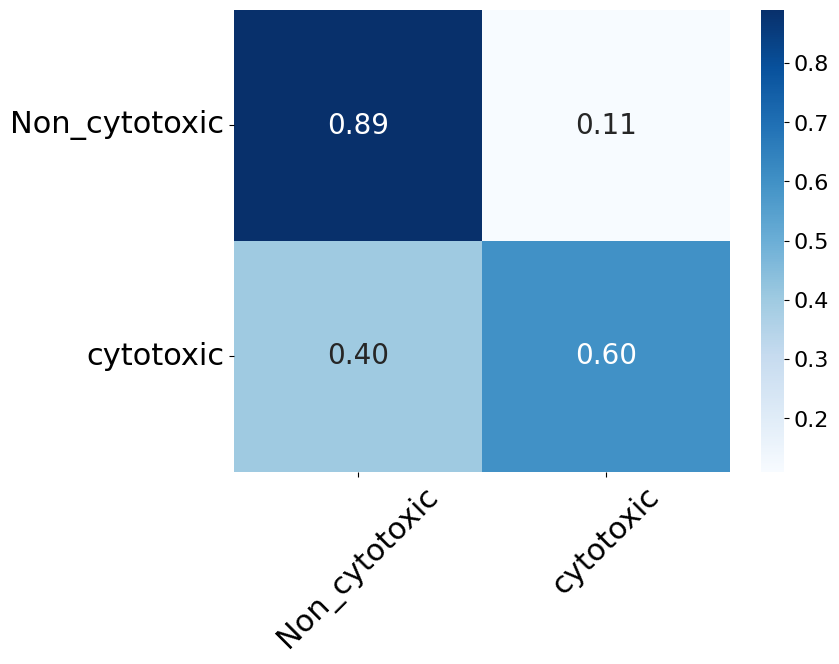


===<catboost.core.CatBoostClassifier object at 0x7f7f50a78bb0> AUC ROC ===
0.8668888888888889


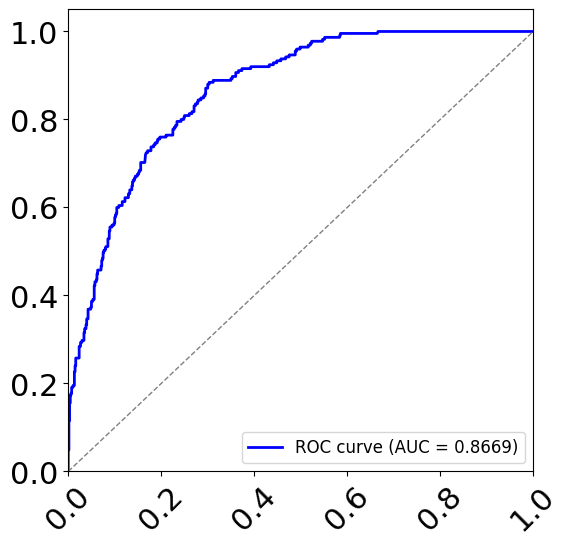

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import pandas as pd

for clf in [gbdt_model, rf_model,lr_model,xgb_model,svr_model,bpnn_model,CatBoost_model]:
        
        clf.fit(X, y)
        y_pred = clf.predict(X_val)
    
        # 如果是二分类，可以用 predict_proba 计算 AUC-ROC
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_val)[:, 1]  # 取正类概率
        else:
            # 没有 predict_proba，用 decision_function
            y_proba = clf.decision_function(X_val)
    
        # 输出每折结果
        # print(f"\n=== Fold {fold} ===")
        print(classification_report(y_val, y_pred, target_names=labels, digits=4))
        cm = confusion_matrix(y_val, y_pred)
        cm_row_percent = cm.astype('float') / cm.sum(axis=1)[:, None]
        # cm_df = pd.DataFrame(cm_row_percent.round(2),
        #                      index=[f"{n}" for n in labels],
        #                      columns=[f"{n}" for n in labels])
        # print("\nConfusion Matrix:\n", cm_df)
        # (可选) 可视化热力图
        # 设置字体大小
        plt.rcParams.update({'font.size': 16})  # 全局字体大小调整
        
        # 画出混淆矩阵
        plt.figure(figsize=(8, 6))  # 图大小
        sns.heatmap(cm_row_percent.round(2), annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})

        # plt.title('Self-attention weighted', fontsize=22)
        # plt.xlabel('Predicted label', fontsize=22)
        # plt.ylabel('True label', fontsize=18)
        plt.xticks(fontsize=22,rotation=45)  # X轴标签字体大小
        plt.yticks(fontsize=22,rotation=0)  # Y轴标签字体大小
        plt.show()
        
        # 输出平均值 ± 标准差
        print(f"\n==={clf} AUC ROC ===")
        
        
        # 假设 y_val 和 y_proba 已经计算好（上一段代码里每折都可用）
        fpr, tpr, thresholds = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)
        print(roc_auc)
        plt.figure(figsize=(6, 6))  # 图大小
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=22,rotation=45)  # X轴标签字体大小
        plt.yticks(fontsize=22,rotation=0)  # Y轴标签字体大小
        # plt.xlabel('False Positive Rate',fontsize=18)
        # plt.ylabel('True Positive Rate',fontsize=18)
        # plt.title('Receiver Operating Characteristic (ROC)',fontsize=22)
        plt.legend(loc="lower right",fontsize=12)
        plt.show()

In [21]:
from sklearn.model_selection import StratifiedKFold


import numpy as np
import pandas as pd

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 保存每折指标
acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []
# for clf in [gbdt_model, rf_model,lr_model,cubist_model,svr_model,bpnn_model,PSO_ANN_model]:

X = shuffled_main_dataset.drop(columns=['Viability_indicator','Cell_viability','Positive_control', 'Positive_control_inducer','SiO$_{2}$NP_label', 'Interference_testing','Viability_mechanism','Assay_viability'], axis=1)
# X = pd.get_dummies(shuffled_main_dataset.drop('Cell_viability', axis=1))
# X = X.drop([
#     'SiO$_{2}$NP_medium_serum_15%_FBS',
#     'Cell_morphology_microglia',

#     'Cell_organ_heart',

#     'Cell_id_MPMC/3t3',

#     'Surface_modification_CHO',
#     'Hydrodynamic_size_water_nm_not_determined',
#     'Cell_source_hamster',
#     'Assay_viability_Sytox_Red',

#     'Viability_indicator_live_cell',
# ], axis=1)

feature_list = [
    "Concentration_µg/ml",
    "SiO$_{2}$NP_medium_serum",
    "Surface_modification",
    "Hydrodynamic_size_culture_nm",
    "Cell_culture",
    "Cell_id",
    "Primary_size_nm",
    "Surface_charge_water",
    "Primary_size_verification",
    "Cell_morphology",
    "Cell_organ",
    "Exposure_time_h",
    "SiO$_{2}$NP_shape",
    "SiO$_{2}$NP_source",
    "Zeta_potential_water_mV",
    "Cell_source",
    "Cell_age",
    "Hydrodynamic_size_water_nm",
    "PDI_water",
    "SiO$_{2}$NP_synthesis",
    "Surface_area_m2/g",
    "Publication_id",
    "Cell_viability"
]

X = shuffled_main_dataset[feature_list]

X = X.drop(columns=['Cell_viability','Publication_id'],axis=1)


y = shuffled_main_dataset[['Cell_viability', 'Publication_id']]
y = y.drop('Publication_id',axis=1)
y = y.to_numpy().ravel()


for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # clf = gbdt_model
    clf = TabPFNClassifier()
    # clf.fit(X_train_scaled.values, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # 如果是二分类，可以用 predict_proba 计算 AUC-ROC
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]  # 取正类概率
    else:
        # 没有 predict_proba，用 decision_function
        y_proba = clf.decision_function(X_test)

    # 分类报告
    report = classification_report(y_test, y_pred, target_names=labels, digits=4, output_dict=True)

    # 提取指标
    acc_list.append(report['accuracy'])
    precision_list.append(report['macro avg']['precision'])
    recall_list.append(report['macro avg']['recall'])
    f1_list.append(report['macro avg']['f1-score'])
    try:
        auc_score = roc_auc_score(y_test, y_proba)
    except:
        auc_score = np.nan
    auc_list.append(auc_score)

    # 输出每折结果
    print(f"\n=== Fold {fold} ===")
    print(classification_report(y_test, y_pred, target_names=labels, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm,
                         index=[f"{n}" for n in labels],
                         columns=[f"{n}" for n in labels])
    # print("\nConfusion Matrix:\n", cm_df)
    # (可选) 可视化热力图
    # sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    # plt.ylabel("True Label")
    # plt.xlabel("Predicted Label")
    # plt.title("Confusion Matrix")
    # plt.show()
# 输出平均值 ± 标准差
print(f"\n==={clf} Overall Metrics ===")
metrics = {
    "Accuracy": acc_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1-score": f1_list,
    "AUC-ROC": auc_list
}

for m, values in metrics.items():
    mean = np.nanmean(values)
    std = np.nanstd(values)
    print(f"{m}: {mean:.4f} ± {std:.4f}")



=== Fold 1 ===
               precision    recall  f1-score   support

Non_cytotoxic     0.9159    0.9400    0.9278       533
    cytotoxic     0.8849    0.8425    0.8632       292

     accuracy                         0.9055       825
    macro avg     0.9004    0.8912    0.8955       825
 weighted avg     0.9049    0.9055    0.9049       825


=== Fold 2 ===
               precision    recall  f1-score   support

Non_cytotoxic     0.9122    0.9362    0.9241       533
    cytotoxic     0.8777    0.8356    0.8561       292

     accuracy                         0.9006       825
    macro avg     0.8950    0.8859    0.8901       825
 weighted avg     0.9000    0.9006    0.9000       825


=== Fold 3 ===
               precision    recall  f1-score   support

Non_cytotoxic     0.9128    0.9231    0.9179       533
    cytotoxic     0.8566    0.8390    0.8478       292

     accuracy                         0.8933       825
    macro avg     0.8847    0.8811    0.8828       825
 weighted

In [22]:
X 

,Concentration_µg/ml,SiO$_{2}$NP_medium_serum,Surface_modification,Hydrodynamic_size_culture_nm,Cell_culture,Cell_id,Primary_size_nm,Surface_charge_water,Primary_size_verification,Cell_morphology,...,Exposure_time_h,SiO$_{2}$NP_shape,SiO$_{2}$NP_source,Zeta_potential_water_mV,Cell_source,Cell_age,Hydrodynamic_size_water_nm,PDI_water,SiO$_{2}$NP_synthesis,Surface_area_m2/g
3828,50.0,serum_free,unmodified,not_determined,cell_line,HepG2,59.72,negative,verified,epithelial,...,72.0,sphere,in_house,negative_31-40,human,non_embryonic,51-75,not_determined,low_temperature,49.724000
189,167.0,serum_free,chitosan,not_determined,cell_line,CCD-966sk,15.20,negative,verified,fibroblast,...,48.0,sphere,in_house,not_determined,human,non_embryonic,not_determined,not_determined,low_temperature,179.425837
644,90.0,serum_free,unmodified,26-50,cell_line,EAHY926,19.40,negative,verified,endothelial,...,24.0,sphere,in_house,not_determined,human,non_embryonic,less_26,not_determined,low_temperature,145.000000
3655,40.0,10%_FBS,unmodified,not_determined,cell_line,16HBE,13.00,negative,verified,epithelial,...,24.0,sphere,in_house,negative_41-50,human,non_embryonic,151-200,0.201-0.3,high_temperature,203.920000
604,10.0,serum_free,unmodified,less_26,cell_line,EAHY926,13.80,negative,verified,endothelial,...,24.0,sphere,commercial,negative_21-30,human,non_embryonic,less_26,not_determined,low_temperature,275.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,300.0,serum_free,unmodified,51-75,cell_line,H441,11.70,negative,verified,epithelial,...,4.0,sphere,commercial,not_determined,human,non_embryonic,less_26,less_0.101,low_temperature,233.100233
24,100.0,10%_FBS,unmodified,not_determined,cell_line,Mono_Mac_6,100.00,negative,verified,monocyte_macrophage,...,24.0,sphere,in_house,not_determined,human,non_embryonic,not_determined,not_determined,low_temperature,27.272727
2066,100.0,serum_free,unmodified,76-100,cell_line,LLC-PK1,85.69,negative,verified,epithelial,...,72.0,sphere,in_house,negative_51-60,pig,non_embryonic,not_determined,not_determined,low_temperature,31.800000
173,667.0,serum_free,unmodified,not_determined,cell_line,A549,80.21,negative,verified,epithelial,...,48.0,sphere,in_house,not_determined,human,non_embryonic,not_determined,not_determined,low_temperature,34.001655


In [23]:
shuffled_main_dataset

,Publication_id,Concentration_µg/ml,SiO$_{2}$NP_medium_serum,Cell_morphology,Cell_organ,Primary_size_nm,Cell_id,Exposure_time_h,Surface_modification,Hydrodynamic_size_water_nm,...,Zeta_potential_PBS/HBSS_mV,Surface_charge_culture,Zeta_potential_serum_mV,Zeta_potential_culture_mV,Cell_age,PDI_culture,Surface_charge_water,SiO$_{2}$NP_label,SiO$_{2}$NP_shape,Cell_viability
3828,104,50.0,serum_free,epithelial,liver,59.72,HepG2,72.0,unmodified,51-75,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,1
189,5,167.0,serum_free,fibroblast,skin,15.20,CCD-966sk,48.0,chitosan,not_determined,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,0
644,14,90.0,serum_free,endothelial,cell_hybrid,19.40,EAHY926,24.0,unmodified,less_26,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,1
3655,100,40.0,10%_FBS,epithelial,lung,13.00,16HBE,24.0,unmodified,151-200,...,not_determined,not_determined,negative_11-20,not_determined,non_embryonic,not_determined,negative,none,sphere,0
604,14,10.0,serum_free,endothelial,cell_hybrid,13.80,EAHY926,24.0,unmodified,less_26,...,not_determined,negative,not_determined,negative_1-10,non_embryonic,not_determined,negative,none,sphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,78,300.0,serum_free,epithelial,lung,11.70,H441,4.0,unmodified,less_26,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,0.101-0.2,negative,rhodamine,sphere,1
24,2,100.0,10%_FBS,monocyte_macrophage,blood,100.00,Mono_Mac_6,24.0,unmodified,not_determined,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,0
2066,64,100.0,serum_free,epithelial,kidney,85.69,LLC-PK1,72.0,unmodified,not_determined,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,1
173,5,667.0,serum_free,epithelial,lung,80.21,A549,48.0,unmodified,not_determined,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,0


In [24]:
shuffled_main_dataset['Cell_viability'].value_counts()

Cell_viability
0    2664
1    1460
Name: count, dtype: int64

In [25]:
feature_list = [
    "Concentration_µg/ml",
    "SiO$_{2}$NP_medium_serum",
    "Surface_modification",
    "Hydrodynamic_size_culture_nm",
    "Cell_culture",
    "Cell_id",
    "Primary_size_nm",
    "Surface_charge_water",
    "Primary_size_verification",
    "Cell_morphology",
    "Cell_organ",
    "Exposure_time_h",
    "SiO$_{2}$NP_shape",
    "SiO$_{2}$NP_source",
    "Zeta_potential_water_mV",
    "Cell_source",
    "Cell_age",
    "Hydrodynamic_size_water_nm",
    "PDI_water",
    "SiO$_{2}$NP_synthesis",
    "Surface_area_m2/g",
    "Publication_id",
    "Cell_viability"
]

X = shuffled_main_dataset[feature_list]

# 每个 label 抽取 500 条
df_sampled = (
    X.groupby('Cell_viability', group_keys=False)
      .apply(lambda x: x.sample(n=1400, random_state=42))
)
# df_sampled = X


X = df_sampled.drop(columns=['Publication_id','Cell_viability'],axis=1)


y = df_sampled[['Cell_viability', 'Publication_id']]
y = y.drop('Publication_id',axis=1)
y = y.to_numpy().ravel()

/tmp/ipykernel_1998/3593431487.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=1400, random_state=42))


In [26]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
X_val

array([[5.0, 10.0, 72.0, ..., False, True, False],
       [15.0, 10.0, 72.0, ..., False, True, False],
       [45.0, 10.0, 72.0, ..., False, True, False],
       ...,
       [20.0, 50.0, 24.0, ..., False, False, True],
       [40.0, 50.0, 24.0, ..., False, False, True],
       [80.0, 50.0, 24.0, ..., False, False, True]], dtype=object)

In [28]:
X_val = independent_dataset[feature_list]

X_val = X_val.drop(columns=['Cell_viability','Publication_id'],axis=1)
y_val = independent_dataset[['Cell_viability', 'Publication_id']]
y_val = y_val.drop('Publication_id',axis=1)
y_val = y_val.to_numpy().ravel()

In [29]:
X_val

,Concentration_µg/ml,SiO$_{2}$NP_medium_serum,Surface_modification,Hydrodynamic_size_culture_nm,Cell_culture,Cell_id,Primary_size_nm,Surface_charge_water,Primary_size_verification,Cell_morphology,...,Exposure_time_h,SiO$_{2}$NP_shape,SiO$_{2}$NP_source,Zeta_potential_water_mV,Cell_source,Cell_age,Hydrodynamic_size_water_nm,PDI_water,SiO$_{2}$NP_synthesis,Surface_area_m2/g
4124,5.0,10%_FBS,unmodified,less_26,cell_line,A549,10.0,negative,not_verified,epithelial,...,72.0,sphere,commercial,negative_11-20,human,non_embryonic,less_26,not_determined,low_temperature,272.727273
4125,15.0,10%_FBS,unmodified,less_26,cell_line,A549,10.0,negative,not_verified,epithelial,...,72.0,sphere,commercial,negative_11-20,human,non_embryonic,less_26,not_determined,low_temperature,272.727273
4126,45.0,10%_FBS,unmodified,less_26,cell_line,A549,10.0,negative,not_verified,epithelial,...,72.0,sphere,commercial,negative_11-20,human,non_embryonic,less_26,not_determined,low_temperature,272.727273
4127,135.0,10%_FBS,unmodified,less_26,cell_line,A549,10.0,negative,not_verified,epithelial,...,72.0,sphere,commercial,negative_11-20,human,non_embryonic,less_26,not_determined,low_temperature,272.727273
4128,405.0,10%_FBS,unmodified,less_26,cell_line,A549,10.0,negative,not_verified,epithelial,...,72.0,sphere,commercial,negative_11-20,human,non_embryonic,less_26,not_determined,low_temperature,272.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5024,5.0,serum_free,unmodified,201-300,cell_line,SO,50.0,negative,verified,neuronal,...,24.0,sphere,commercial,negative_11-20,rat,non_embryonic,201-300,not_determined,not_available,54.545455
5025,10.0,serum_free,unmodified,201-300,cell_line,SO,50.0,negative,verified,neuronal,...,24.0,sphere,commercial,negative_11-20,rat,non_embryonic,201-300,not_determined,not_available,54.545455
5026,20.0,serum_free,unmodified,201-300,cell_line,SO,50.0,negative,verified,neuronal,...,24.0,sphere,commercial,negative_11-20,rat,non_embryonic,201-300,not_determined,not_available,54.545455
5027,40.0,serum_free,unmodified,201-300,cell_line,SO,50.0,negative,verified,neuronal,...,24.0,sphere,commercial,negative_11-20,rat,non_embryonic,201-300,not_determined,not_available,54.545455


               precision    recall  f1-score   support

Non_cytotoxic     0.8864    0.9294    0.9074       680
    cytotoxic     0.7500    0.6400    0.6906       225

     accuracy                         0.8575       905
    macro avg     0.8182    0.7847    0.7990       905
 weighted avg     0.8525    0.8575    0.8535       905



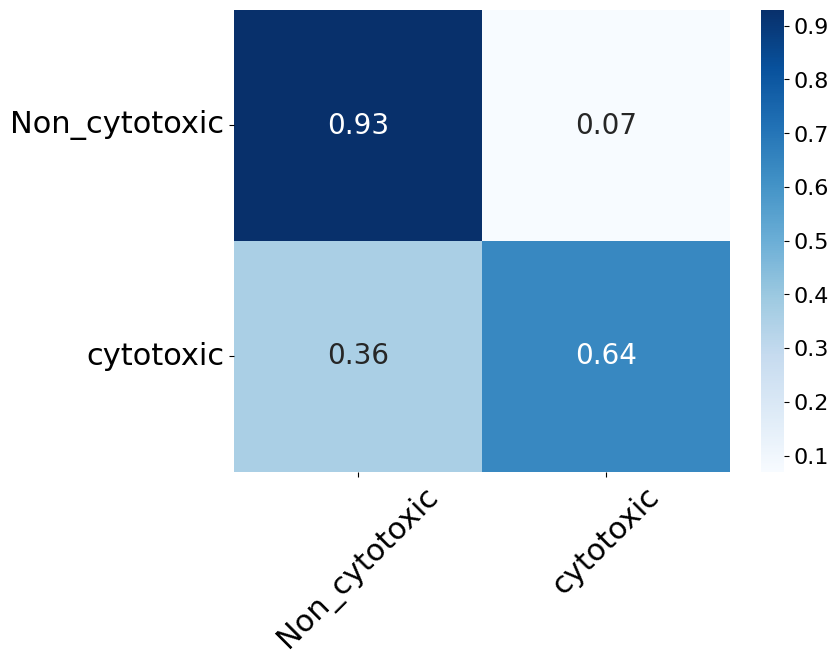


===TabPFNClassifier() AUC ROC ===
0.8937026143790849


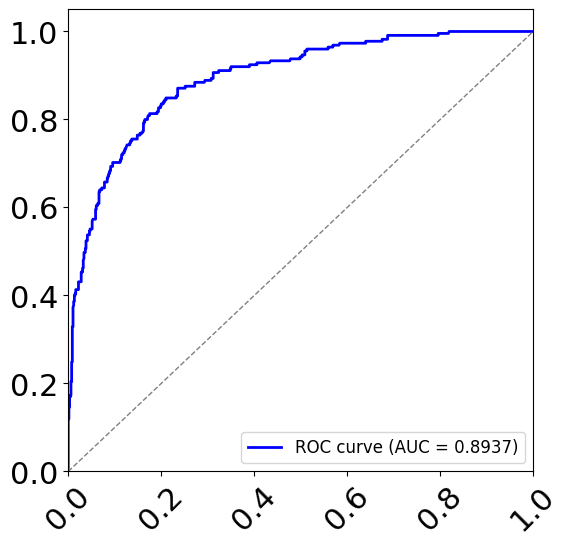

In [30]:
clf = TabPFNClassifier()
clf.fit(X.values, y)
y_pred = clf.predict(X_val.values)

# 如果是二分类，可以用 predict_proba 计算 AUC-ROC
if hasattr(clf, "predict_proba"):
    y_proba = clf.predict_proba(X_val.values)[:, 1]  # 取正类概率
else:
    # 没有 predict_proba，用 decision_function
    y_proba = clf.decision_function(X_val.values)

# 输出每折结果
# print(f"\n=== Fold {fold} ===")
print(classification_report(y_val, y_pred, target_names=labels, digits=4))
cm = confusion_matrix(y_val, y_pred)
cm_row_percent = cm.astype('float') / cm.sum(axis=1)[:, None]
# cm_df = pd.DataFrame(cm_row_percent.round(2),
#                      index=[f"{n}" for n in labels],
#                      columns=[f"{n}" for n in labels])
# print("\nConfusion Matrix:\n", cm_df)
# (可选) 可视化热力图
# 设置字体大小
plt.rcParams.update({'font.size': 16})  # 全局字体大小调整

# 画出混淆矩阵
plt.figure(figsize=(8, 6))  # 图大小
sns.heatmap(cm_row_percent.round(2), annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})

# plt.title('Self-attention weighted', fontsize=22)
# plt.xlabel('Predicted label', fontsize=22)
# plt.ylabel('True label', fontsize=18)
plt.xticks(fontsize=22,rotation=45)  # X轴标签字体大小
plt.yticks(fontsize=22,rotation=0)  # Y轴标签字体大小
plt.show()

# 输出平均值 ± 标准差
print(f"\n==={clf} AUC ROC ===")


# 假设 y_val 和 y_proba 已经计算好（上一段代码里每折都可用）
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure(figsize=(6, 6))  # 图大小
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=22,rotation=45)  # X轴标签字体大小
plt.yticks(fontsize=22,rotation=0)  # Y轴标签字体大小
# plt.xlabel('False Positive Rate',fontsize=18)
# plt.ylabel('True Positive Rate',fontsize=18)
# plt.title('Receiver Operating Characteristic (ROC)',fontsize=22)
plt.legend(loc="lower right",fontsize=12)
plt.show()